### Imports

In [1]:
# Standard library
import concurrent.futures
import sqlite3
import os

# Third-party
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Local application
from kickbase_api.player_data import (
    get_all_players,
    get_player_id,
    get_player_info,
    get_player_market_value,
    get_player_performance,
)
from kickbase_api.league_data import (
    get_leagues_infos,
    get_budget,
    get_players_on_market,
)
from kickbase_api.user_management import login
from kickbase_api.team_data import get_matchdays

### Login to Kickbase

In [2]:
# Load environment variables from .env file
load_dotenv() 
USERNAME = os.getenv("KICK_USER")
PASSWORD = os.getenv("KICK_PASS")

# Login and get token
token = login(USERNAME, PASSWORD)

### Connect to SQLite Database

In [3]:
conn = sqlite3.connect("player_data_total.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS player_data_1d (
    player_id INTEGER,
    team_id INTEGER,
    team_name TEXT,
    first_name TEXT,
    last_name TEXT,
    position TEXT,
    md DATE,
    date DATE,
    p REAL,
    mp INTEGER,
    ppm REAL,
    t1 INTEGER,
    t2 INTEGER,
    t1g INTEGER,
    t2g INTEGER,
    won INTEGER,
    k TEXT,
    mv REAL
);
""")

conn.commit()

### Get Player Data from Kickbase and Store in Database

In [4]:
competition_ids = [1]   # 1 = Bundesliga, 2 = 2. Bundesliga, 3 = La Liga
last_mv_values = 365    # in days, max 365
last_pfm_values = 50    # in matchdays, max idk

# Get current date and time
now = datetime.now()
today = now.date()
current_hour = now.hour

# Get nearest entry to today where mv is null
with sqlite3.connect("player_data_total.db") as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT date FROM player_data_1d WHERE mv IS NULL ORDER BY date ASC LIMIT 1;")
    last_null_entry = cursor.fetchone()

    # convert last_null_entry (timestamp) to date
    if last_null_entry is not None:
        last_null_entry = datetime.fromisoformat(last_null_entry[0]).date()

    # If this entry is after today then we are up to date
    if last_null_entry is not None and last_null_entry > today:
        reload_data = False
    # If this entry is today and it is before 22:00 then we are up to date
    elif last_null_entry is not None and last_null_entry == today and current_hour < 22:
        reload_data = False
    # All other cases: last entry before today or last entry today but after 22:00
    else:
        reload_data = True

In [5]:
if reload_data:
    all_competitions_dfs = []

    for competition_id in competition_ids:
        players = get_all_players(token, competition_id)

        def process_player(player_id):
            player_info = get_player_info(token, competition_id, player_id)
            player_team_id = player_info["team_id"]
            player_df = pd.DataFrame([player_info])

            # Market Value
            mv_df = pd.DataFrame(get_player_market_value(token, competition_id, player_id, last_mv_values))
            if not mv_df.empty:
                mv_df["date"] = pd.to_datetime(mv_df["date"]).sort_values()

            # Performance
            p_df = pd.DataFrame(get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id))
            if not p_df.empty:
                p_df["date"] = pd.to_datetime(p_df["date"]).sort_values()
            else:
                p_df = pd.DataFrame({"date": pd.to_datetime([])})

            # Merge DataFrames
            merged_df = (
                pd.merge_asof(mv_df, p_df, on="date", direction="backward")
                if not mv_df.empty else pd.DataFrame()
            )

            # Get p_df values where p_df.date > max(mv_df.date) and append to merged_df
            if not p_df.empty and not mv_df.empty:
                max_mv_date = mv_df["date"].max()
                additional_p_df = p_df[p_df["date"] > max_mv_date]
                merged_df = pd.concat([merged_df, additional_p_df], ignore_index=True) 

            if not merged_df.empty:
                merged_df = player_df.merge(merged_df, how="cross")
                merged_df["competition_id"] = competition_id

            return merged_df

        # Use ThreadPoolExecutor to parallelize player fetching
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            comp_dfs = list(executor.map(process_player, players))
        
        comp_final_df = pd.concat(
            [df.dropna(how="all", axis=1) for df in comp_dfs if df is not None and not df.empty],
            ignore_index=True
        )

        
        all_competitions_dfs.append(comp_final_df)

    # Combine all competitions
    final_df = pd.concat(all_competitions_dfs, ignore_index=True)

    # Convert k column to string
    final_df["k"] = final_df["k"].apply(
        lambda x: ",".join(map(str, x)) if isinstance(x, list) else (None if x is None else str(x))
    )

    # Save to SQLite
    with sqlite3.connect("player_data_total.db") as conn:
        final_df.to_sql("player_data_1d", conn, if_exists="replace", index=False)

In [6]:
conn = sqlite3.connect("player_data_total.db")
df = pd.read_sql("SELECT * FROM player_data_1d", conn)
conn.close()

### Preprocess Data

In [7]:
# 1. Sort and filter
df = df.sort_values(["player_id", "date"])
df = df[(df["team_id"] == df["t1"]) | (df["team_id"] == df["t2"])]  # keep only t1 or t2

# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])
df["md"] = pd.to_datetime(df["md"])

# 2. Date and matchday calculations 
df["next_day"] = df.groupby("player_id")["date"].shift(-1) 
df["next_md"] = df.groupby("player_id")["md"].transform(
    lambda x: x.shift(-1).where(x.shift(-1) != x).bfill()
)
df["days_to_next"] = (df["next_md"] - df["date"]).dt.days

# 3. Next day market value
df["mv_next_day"] = df.groupby("player_id")["mv"].shift(-1)
df["mv_target"] = df["mv_next_day"] - df["mv"]
df = df[df["mv"] != 0.0]

# 4. Feature engineering 
# Market value trend 1d
df["mv_change_1d"] = df["mv"] - df.groupby("player_id")["mv"].shift(1)
df["mv_trend_1d"] = df.groupby("player_id")["mv"].pct_change(fill_method=None)
df["mv_trend_1d"] = df["mv_trend_1d"].replace([np.inf, -np.inf], 0).fillna(0)

# Market value trend 3d
df["mv_change_3d"] = df["mv"] - df.groupby("player_id")["mv"].shift(3)
df["mv_vol_3d"] = df.groupby("player_id")["mv"].rolling(3).std().reset_index(0,drop=True)

# Market value trend 7d
df["mv_trend_7d"] = df.groupby("player_id")["mv"].pct_change(periods=7, fill_method=None)
df["mv_trend_7d"] = df["mv_trend_7d"].replace([np.inf, -np.inf], 0).fillna(0)

## League-wide market context
df["market_divergence"] = (df["mv"] / df.groupby("md")["mv"].transform("mean")).rolling(3).mean()

# 5. Clip outliers in mv_target
Q1 = df["mv_target"].quantile(0.25)
Q3 = df["mv_target"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

df["mv_target_clipped"] = df["mv_target"].clip(lower_bound, upper_bound)

# 6. Fill missing values
df = df.fillna({
    "market_divergence": 1,
    "mv_change_3d": 0,
    "mv_vol_3d": 0,
    "p": 0,
    "ppm": 0,
    "won": -1
})

# 7. Cutout todays values and store them
now = datetime.now()
max_date = (now - timedelta(days=1)) if now.hour <= 22 else now
max_date = max_date.date()

today_df = df[df["date"].dt.date >= max_date]

# Drop those values from today from df
df = df[df["date"].dt.date < max_date]

# 8. Drop rows with NaN in critical columns
df = df.dropna(subset=["mv_change_1d", "next_day", "next_md", "days_to_next", "mv_next_day", "mv_target", "mv_target_clipped"])

### Select Features and Target Variable

In [8]:
# TODO Add features like starting 11 probability, injuries, ...
features = [
    "p", "mv", "days_to_next", 
    "mv_change_1d", "mv_trend_1d", 
    "mv_change_3d", "mv_vol_3d",
    "mv_trend_7d", "market_divergence"
]

target = "mv_target_clipped" # or "mv_target"

# Split by time, to avoid data leakage
train = df[df["date"] < "2025-01-01"]
test = df[(df["date"] >= "2025-01-01")]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Train Machine Learning Model

In [9]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
signs_correct = np.sum(np.sign(y_test) == np.sign(y_pred))

print(f"Sign accuracy: {np.round((signs_correct / len(y_test)) * 100, 2)}%")
print(f"RMSE: {np.round(rmse, 2)}")
print(f"MAE: {np.round(mae, 2)}")
print(f"R²: {np.round(r2, 3)}")

Sign accuracy: 66.87%
RMSE: 3015596257.93
MAE: 28160.39
R²: 0.816


### Example Player Prediction

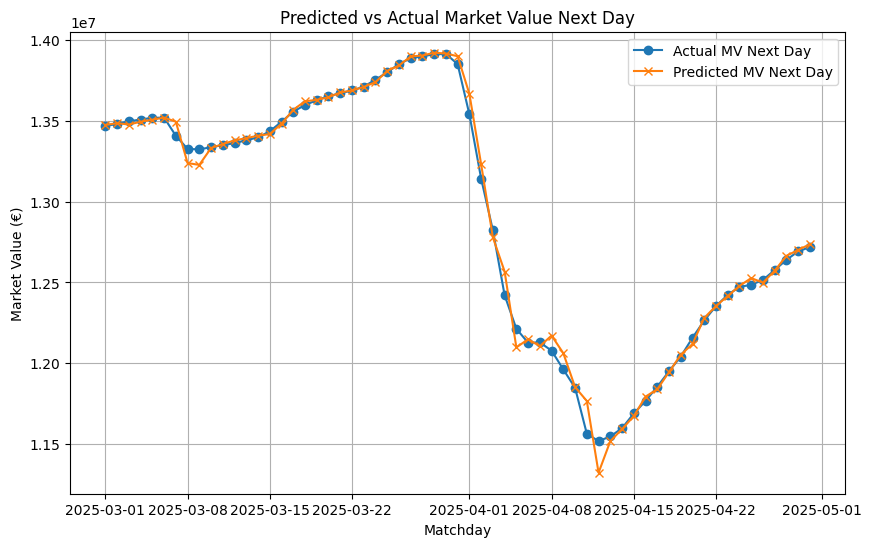

In [10]:
small_test = test[["player_id", "first_name", "last_name", "date", "mv", "mv_next_day", "mv_target"]].copy()

small_test["predicted_mv_target"] = np.round(y_pred, 2)
small_test["predicted_mv_next_day"] = small_test["mv"] + small_test["predicted_mv_target"]


# get error between prediction and actual 
small_test["error"] = small_test["mv_next_day"] - small_test["predicted_mv_next_day"]

# Sort by error ascending

small_test = small_test.sort_values("date")

small_test = small_test[(small_test["last_name"] == "Eggestein")]


# Filter small test only between 2025-03 and 2025-04
small_test = small_test[(small_test["date"] >= "2025-03-01") & (small_test["date"] <= "2025-04-30")]


# Plot predicted vs actual mv_next_week
plt.figure(figsize=(10, 6))
plt.plot(small_test["date"], small_test["mv_next_day"], marker='o', label="Actual MV Next Day")
plt.plot(small_test["date"], small_test["predicted_mv_next_day"], marker='x', label="Predicted MV Next Day")
plt.xlabel("Matchday")
plt.ylabel("Market Value (€)")
plt.title("Predicted vs Actual Market Value Next Day")
plt.legend()
plt.grid(True)


### Live Data Prediction

In [11]:
today_df_features = today_df[features]

today_df_results = today_df.copy()

today_df_results["predicted_mv_target"] = np.round(model.predict(today_df_features), 2)

# Sort by predicted_mv_target descending
today_df_results = today_df_results.sort_values("predicted_mv_target", ascending=False)

# Filter date to today 
now = datetime.now()
date = (now - timedelta(days=1)) if now.hour <= 22 else now
date = date.date()
today_df_results = today_df_results[today_df_results["date"].dt.date == date]

# Drop rows where NaN mv
today_df_results = today_df_results.dropna(subset=["mv"])

# Keep only relevant columns
today_df_results = today_df_results[["player_id", "first_name", "last_name", "position", "team_name", "date", "mv_change_1d", "mv_trend_1d", "mv", "predicted_mv_target"]]

display(today_df_results)

,player_id,first_name,last_name,position,team_name,date,mv_change_1d,mv_trend_1d,mv,predicted_mv_target
133948,3301,Adam,Dźwigała,2,St. Pauli,2025-09-01,450869.0,0.134122,3812513.0,399383.54
110526,8247,Ramon,Hendriks,2,Stuttgart,2025-09-01,437188.0,0.169433,3017484.0,389765.94
50505,3230,Umut,Tohumcu,3,Hoffenheim,2025-09-01,371037.0,0.138595,3048168.0,374071.44
108696,3193,None,Tiago Tomás,4,Stuttgart,2025-09-01,403331.0,0.048457,8726857.0,372391.24
47943,1671,Grischa,Prömel,3,Hoffenheim,2025-09-01,399937.0,0.100569,4376666.0,372113.52
...,...,...,...,...,...,...,...,...,...,...
19395,841,Patrick,Mainka,2,Heidenheim,2025-09-01,-418899.0,-0.031452,12899780.0,-387023.22
12441,2255,Jonathan,Burkardt,4,Frankfurt,2025-09-01,-559376.0,-0.016710,32916764.0,-388406.73
4390,4199,Aleix,García,3,Leverkusen,2025-09-01,-653457.0,-0.036245,17375414.0,-388617.26
109428,7158,Deniz,Undav,4,Stuttgart,2025-09-01,-1170489.0,-0.042427,26417977.0,-389574.55


In [12]:
league_infos = get_leagues_infos(token)
league_id = league_infos[0]["id"]

players_on_market = get_players_on_market(token, league_id)

# players_on_market to DataFrame
market_df = pd.DataFrame(players_on_market)

# Join market_df ("id") with today_df ("player_id")
bid_df = (
    pd.merge(today_df_results, market_df, left_on="player_id", right_on="id")
    .drop(columns=["id"])
)

# exp contains seconds until expiration
bid_df["hours_to_exp"] = np.round((bid_df["exp"] / 3600), 2)

# check if current sysdate + hours_to_exp is after the next 22:00
now = datetime.now()
next_22 = now.replace(hour=22, minute=0, second=0, microsecond=0)
diff = np.round((next_22 - now).total_seconds() / 3600, 2)

# If hours_to_exp < diff then it expires today
bid_df["expiring_today"] = bid_df["hours_to_exp"] < diff

# Sort by predicted_mv_target descending
bid_df = bid_df.sort_values("predicted_mv_target", ascending=False)
display(bid_df[["first_name", "last_name", "position", "team_name", "mv", "mv_change_1d", "predicted_mv_target", "prob", "hours_to_exp", "expiring_today"]])

,first_name,last_name,position,team_name,mv,mv_change_1d,predicted_mv_target,prob,hours_to_exp,expiring_today
0,None,Tiago Tomás,4,Stuttgart,8726857.0,403331.0,372391.24,3.0,6.05,False
1,Leart,Pacarada,2,Heidenheim,2776395.0,341005.0,337597.92,2.0,17.91,False
2,Yan,Couto,2,Dortmund,9769839.0,356398.0,336971.31,3.0,536.54,False
3,Lukas,Ullrich,2,M'gladbach,7915394.0,338357.0,320892.80,3.0,19.34,False
4,Jonas,Meffert,3,Hamburg,1429846.0,276590.0,259813.45,5.0,717.00,False
5,Ridle,Baku,3,Leipzig,11966113.0,252529.0,259192.82,2.0,4.88,False
6,Nicolai,Remberg,3,Hamburg,8851229.0,261118.0,247341.15,2.0,675.63,False
7,Jackson,Irvine,3,St. Pauli,4742001.0,72896.0,167290.21,5.0,12.63,False
8,Yussuf,Poulsen,4,Hamburg,8873618.0,134365.0,158127.05,3.0,27.76,False
9,Robin,Hack,3,M'gladbach,18010748.0,135705.0,126595.61,1.0,468.76,False
